In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.8/8062.4 GB disk)


In [6]:
%%writefile data.yaml

path: /kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch
train: train/images
val: valid/images
test: test/images
names:
  0: Crop
  1: Weed

nc: 2

Overwriting data.yaml


In [7]:
!python train.py --img 640 --batch 16 --epochs 15 --data data.yaml --weights yolov5x.pt --cache 

2024-07-21 21:33:16.946072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 21:33:16.946192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 21:33:17.067431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimi

In [9]:
!python detect.py --source /kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images --img 640 --conf 0.25 --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
image 1/118 /kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg: 384x640 1 Weed, 68.5ms
image 2/118 /kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images/1219

In [14]:
!pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      /opt/conda/lib/python3.10/site-packages/setuptools/dist.py:458: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              By 2024-Sep-26, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
 

In [23]:

from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image



ROOT_DIR = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'
classes = ['Crop','Weed']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax


def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

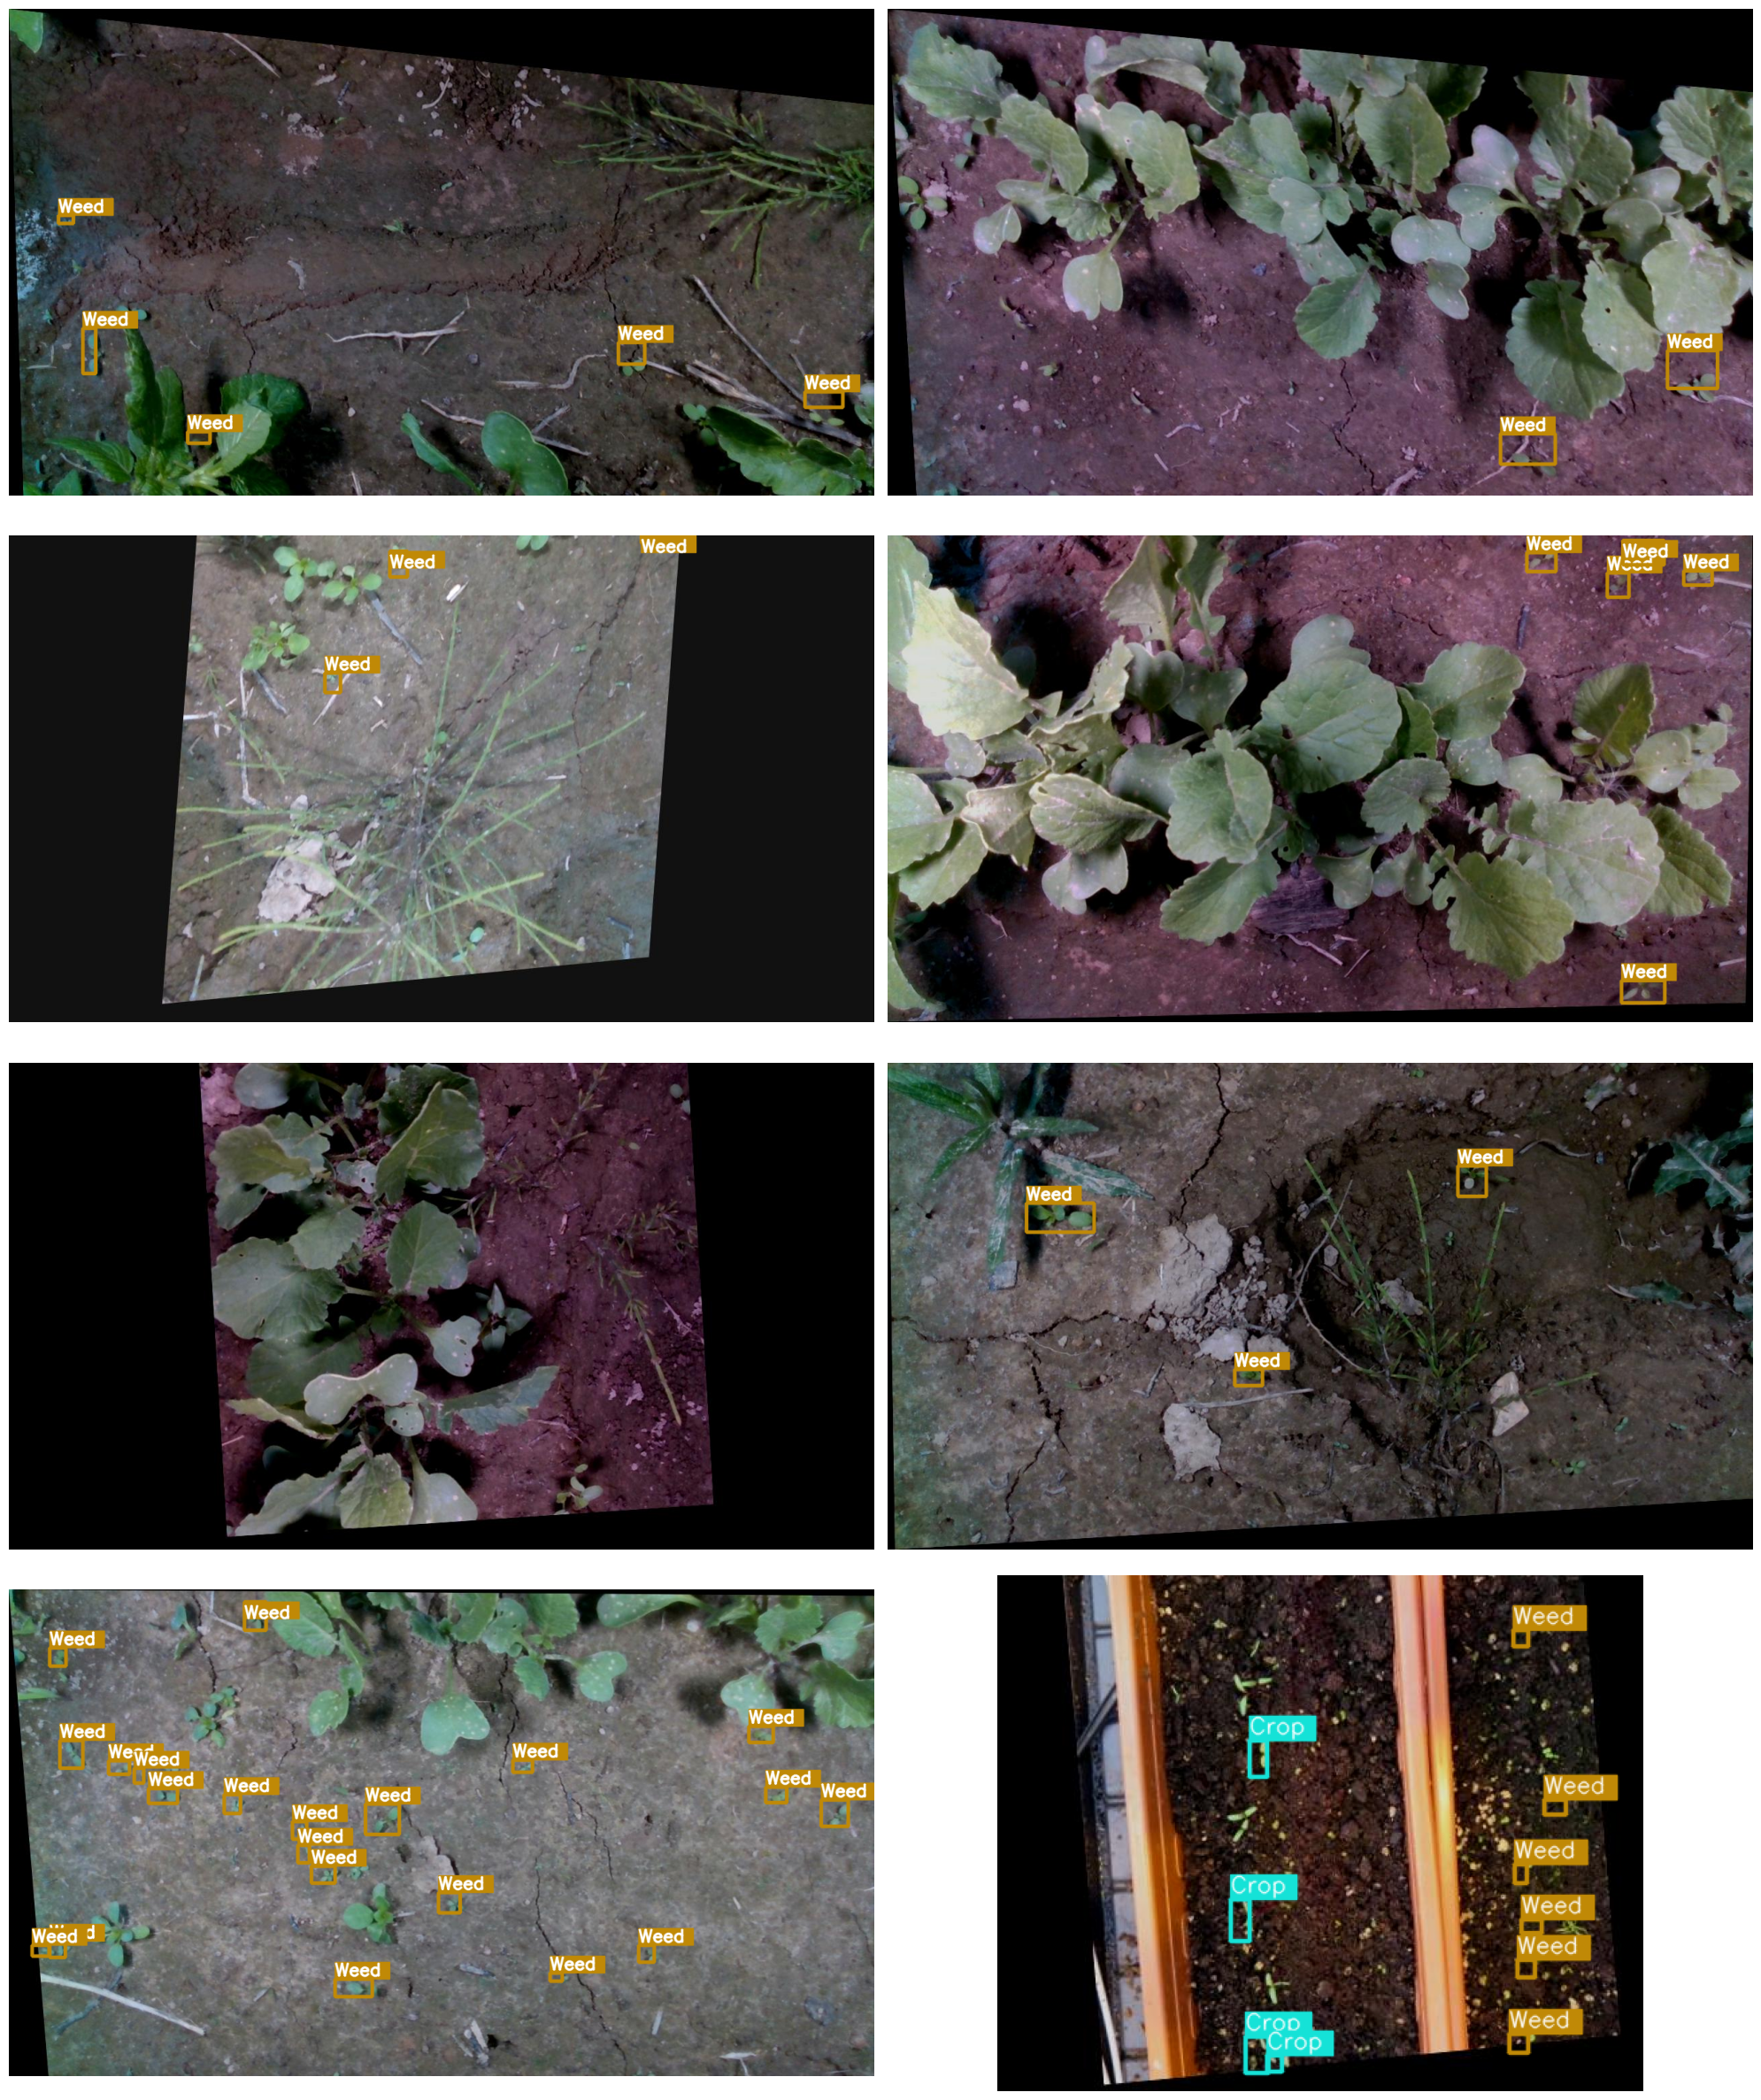

In [24]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import os

log_dir = "/kaggle/working/yolov5/runs/detect/exp2"
image_extensions = ('.png', '.jpg', '.jpeg')
image_paths = sorted([os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.lower().endswith(image_extensions)])

print(f"Found {len(image_paths)} images in {log_dir}")

for image_path in image_paths:
    try:
        print(f"Processing {image_path}")
        image = Image.open(image_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Cannot identify image file {image_path}: {e}")

Found 118 images in /kaggle/working/yolov5/runs/detect/exp2
Processing /kaggle/working/yolov5/runs/detect/exp2/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg
Cannot identify image file /kaggle/working/yolov5/runs/detect/exp2/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg: cannot identify image file '/kaggle/working/yolov5/runs/detect/exp2/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg'
Processing /kaggle/working/yolov5/runs/detect/exp2/12198_jpg.rf.a216dcc7b89a168893ccd130a89553ee.jpg
Cannot identify image file /kaggle/working/yolov5/runs/detect/exp2/12198_jpg.rf.a216dcc7b89a168893ccd130a89553ee.jpg: cannot identify image file '/kaggle/working/yolov5/runs/detect/exp2/12198_jpg.rf.a216dcc7b89a168893ccd130a89553ee.jpg'
Processing /kaggle/working/yolov5/runs/detect/exp2/12205_jpg.rf.ab3db8b3b513ffeae1e66458ae3b1df9.jpg
Cannot identify image file /kaggle/working/yolov5/runs/detect/exp2/12205_jpg.rf.ab3db8b3b513ffeae1e66458ae3b1df9.jpg: cannot identify image file '/kaggle/working/y